In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

%matplotlib inline

Matplotlib created a temporary config/cache directory at /var/folders/rf/wfq6hz5s56g3yh4wqgd7820c0000gn/T/matplotlib-5yx9ouar because the default path (/Users/nreilly/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


The first step of the analysis is to make some assumptions about the DDS engine we'll be working with here. 

I'm setting a stretch goal of a 100MHz clock frequency/sample rate for the DDS, and an accumulator depth of 32 bits. 

That gives us a frequency resolution of:

$F_{res} = \frac{F_{clock}}{2^{N}} = \frac{100 MHz}{2^{32}} = ~0.02 Hz$

To save some brain sweat, I'm going to write two quick functions to interchange frequencies and tuning words:

In [3]:
# Returns the frequency tuning word for a desired frequency output 
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def freq_to_tuning(freq_out, sample_rate=100000000, acc_depth=32):
    return int((freq_out * (2**acc_depth))/sample_rate)

# Returns the frequency output for a given frequency tuning word
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def tuning_to_freq(tuning_word, sample_rate=100000000, acc_depth=32):
    return (tuning_word * sample_rate) / float(2 ** acc_depth)

Note, too, that these aren't perfect exchanges. There's some quantization error inherent in a digital system - that's the frequency resolution we calculated a second ago. You can see this by just jumping back and forth between formats, and noting the error between the conversions:

In [25]:
freq = 12500001
tuning = freq_to_tuning(freq)
freq_actual = tuning_to_freq(tuning)

error = ((freq_actual - freq)/freq) * 100
print(f"{freq} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

12500001 Hz signal: 0x2000002a
12500000.977888703 Hz signal: 0x2000002a (-1.7689035907875175e-07)


There's also error introduced in the way that Python truncates rather than rounds when converting between `float` and `int`. Astute readers have likely noted that the _next_ value, `0x0739b025`, actually produces a lower-error signal. Tuning code `0x0739b025` produces an output of 2822400.0008776784 Hz rather than the original 2822399.977594614 Hz: 

In [26]:
tuning = tuning + 1
freq_actual = tuning_to_freq(tuning)
error = ((freq_actual - freq)/freq) * 100
print(f"{freq_actual} Hz signal: {tuning:#010x}")
print(f"{freq_actual} Hz signal: {tuning:#010x} ({error})")

12500001.001171768 Hz signal: 0x2000002b
12500001.001171768 Hz signal: 0x2000002b (9.374140943183958e-09)


Worth noting: a typical uncompensated quartz crystal will vary around 25-50ppm in frequency when installed into an oscillator circuit. Whether or not this is something you need to lose sleep over is specific to your application. Odds are this is a totally appropriate amount of jitter for your frequency synthesis application. (If it's not, then you're probably working on something like an atomic clock. If you _are_ working on an atomic clock, and you're reading this page for advice on timing jitter, you've got bigger problems on your plate than frequency synthesis.) Ethernet phys and Bluetooth ICs the world over happily run with oscillator reference tolerances in the 25ppm range, and reliably serve up phone calls, Spotify streams, and cat photos to people every day. 

Anywhoozles: using that rather gnarly 32 bit number `0x0739b025` as our genesis point, we can generate a sample phase accumulator output using the following code block:

Text(0.5, 1.0, 'DDS Output')

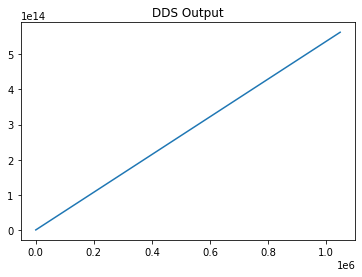

In [27]:
# Generates a phase accumulator output for a given tuning word
phase = [ 0 ]
while len(phase) < (2**20):
    phase.append(phase[-1] + tuning)

plt.plot(phase)
plt.title("DDS Output")

OK, great. The chart goes up, and to the right. (The business unit will be _ecstatic_.) Eventually, it's going to just roll over to zero, and keep on counting up. That's not a big deal! This is a *phase* accumulator; phase wraps around from $2\pi$ back to zero. As long as `0x00000000` corresponds to 0 degrees phase, you're in the clear! 

The phase accumulator has a couple more fortunate features for us besidse phase wrapping. At some point, we're gonna need to convert _phase_ to _amplitude_. The easiest (and also fastest) way to do this is with a lookup table, or a simple ROM. If phase wasn't a parameter that rolled over, we'd be up shit creek without an infinite memory paddle. It's also complete and absolute overkill to use all the possible addresses generated by a 32 bit phase accumulator. That'd produce a ~4GB lookup table of sine values! 

The accumulator instead gets _truncated_ down to its most significant bits - in this case, the 12 MSBs (note: dumping all of these into a pandas dataframe to keep them organized):

In [28]:
df_phase = pd.DataFrame(zip(phase, [tuning] * len(phase)), columns=['phase', 'tuning'])
df_phase['phase_trunc'] = np.bitwise_and(df_phase['phase'], 0xFFC00000)
df_phase['phase_trunc'] = np.right_shift(df_phase['phase_trunc'], 20)

A short function allows us to generate sine lookup ROMs really quickly:

In [29]:
# Generate a rom table of a sine wave with signed integers 
def generate_sin_rom(bits, rom_depth):
    # Subtract 1 from bit depth for signed data (msb is sign bit)
    amplitude = 2**(bit_depth-1)
    sin_rom = [int(amplitude * math.sin(a/rom_depth * 2 * math.pi)) for a in range(rom_depth)]
    return(sin_rom)

bit_depth = 12
rom_size = 4096
sin_rom = generate_sin_rom(bit_depth, rom_size)

...and a lambda function allows us to turn this into a sine wave, toot sweet.

<AxesSubplot:>

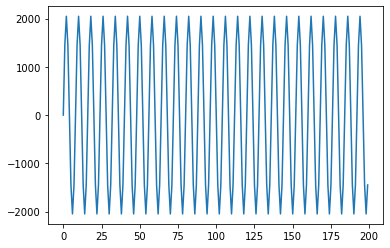

In [30]:
# Lambda function serves as phase-to-amplitude converter
df_phase['dds_out'] = df_phase['phase_trunc'].apply(lambda x: sin_rom[x])
df_phase['dds_out'][:200].plot()

No big deal if you didn't follow all of that. Here's the truncated phase, the sine output, and the frequency spectrum of that output sine signal:

<ipython-input-31-cd7e11b35c78>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3,1,3)


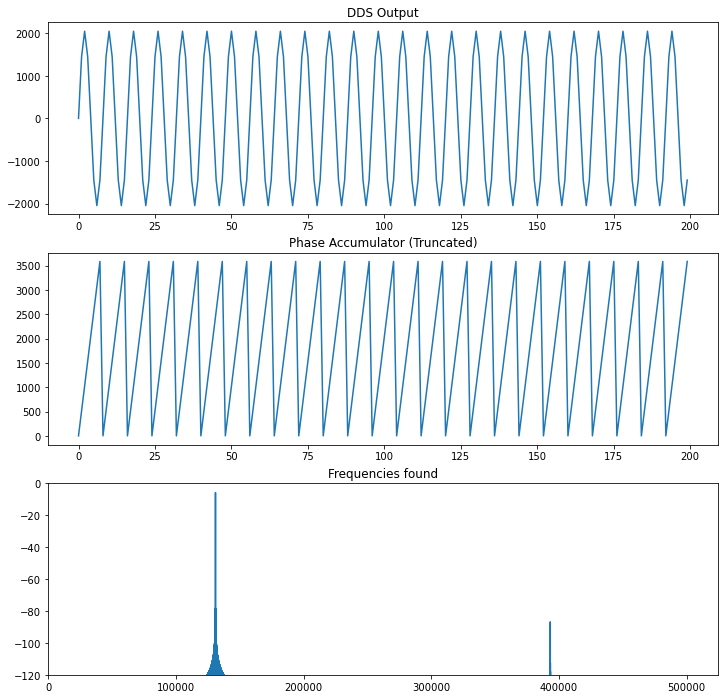

In [31]:
data_fft = np.fft.fft(df_phase['dds_out'])
frequencies = np.abs(data_fft)
freq_scale = frequencies * 2 / len(frequencies)
db_freqs = freq_scale / float(2**(bit_depth))
db_freqs = (20 * np.log10(db_freqs))

# Shortening the time domain plot so sine features are visible
plot_len = 200

fig = plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(df_phase['dds_out'][:plot_len])
plt.title("DDS Output")

plt.subplot(3,1,2)
plt.plot(df_phase['phase_trunc'][:plot_len])
plt.title("Phase Accumulator (Truncated)")

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(3,1,3)
ax = fig.add_subplot(3,1,3)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])
#ax.set_yscale('symlog')
fft_ticklabels = ax.get_xticklabels()
fft_ticklines = ax.get_xticklines()

fft_index = int(len(frequencies)/2) # Half of the FFT output 
#fft_index = 5000
#plt.plot(db_freqs[:fft_index])
plt.plot(db_freqs)

plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()

Cool! There are a few regular tones that you can see peeking out of the noise in the FFT above. We care about these because these determine how spectrally pure the intended output is. Hip cats in the signal processing world call this the "spur free dynamic range", or SFDR. That's the official name for the difference between your desired signal's magnitude to the magnitude of the first undesirable harmonic. This is quick to find with a few lines of Python:  sort the magnitudes of the FFT bins, and subtract the second-highest magnitude bin from the the highest-magnitude bin (a.k.a. "the carrier").

In [23]:
len_db_freqs = int(len(db_freqs)/2)
largest_peaks = sorted(db_freqs[:len_db_freqs])[-10:]
print(largest_peaks)
sfdr = largest_peaks[-1] - largest_peaks[-2]
print()
print(f"the SFDR of this signal is {sfdr} dBc")

[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -91.46837372503745, -6.021063826996881]

the SFDR of this signal is 85.44730989804057 dBc


This is a bit worse than the ~60dB of SFDR shown in the FFT above. Still sniffing around as to why the worst spurs don't show up as higher magnitudes on the FFT. I suspect it's some power term or squaring that I'm not accounting for. 

Plotting diffifculties aside, 40dBc (that's "decibels relative to carrier") is not really a _great_ signal to noise ratio in terms of digital synthesis. There are a few regular tones that you can see peeking out of the noise in the above FFT. Going to a log scale on the x axis (frequency axis) shows that the noise is really concentrated around the higher frequencies.

<ipython-input-24-c538846b76c2>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,1)
<ipython-input-24-c538846b76c2>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,2)
<ipython-input-24-c538846b76c2>:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,fft_index)


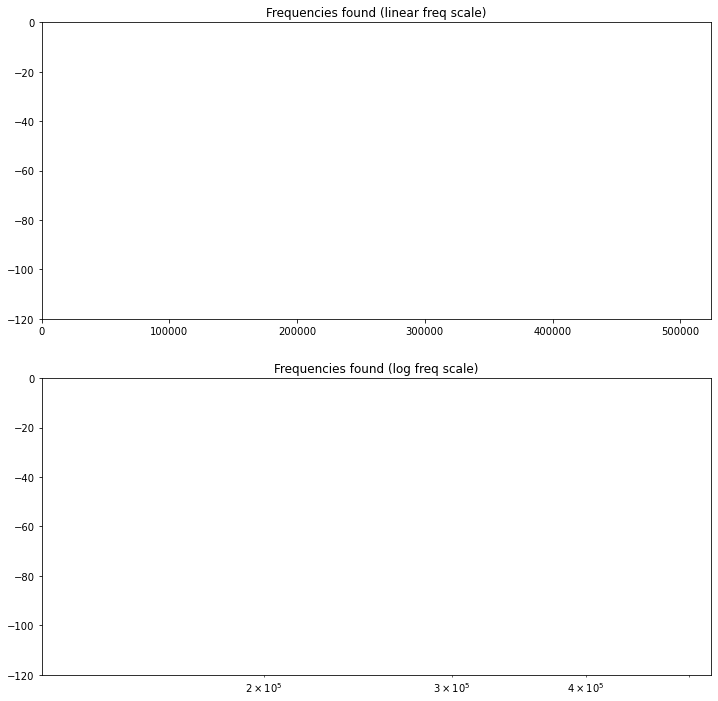

In [24]:
fig = plt.figure(figsize=(12,12))
fft_index = int(len(frequencies)/2) # Half of the FFT output 

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(2,1,1)
ax = fig.add_subplot(2,1,1)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

plt.plot(db_freqs[:fft_index])
plt.title("Frequencies found (linear freq scale)")
plt.xlim(0,fft_index)

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_xscale('log')
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

plt.plot(db_freqs[:fft_index])
plt.title("Frequencies found (log freq scale)")
plt.xlim(0,fft_index)
plt.show()

So, what can we do about all of this excess noise, and these tones degrading our SFDR? 

There's a few more neat tricks on how to get around this, including:

* Increasing the bit depth of your sin rom
* Increasing the ROM depth of your sin rom
* Dithering
* Taylor series correction

I'll dig more into each of those in good time. 

# Dope Links for Cool Cats 


## Direct Digital Synthesis

Analog Devices has long been the leader in high speed DACs and ADCs, so, naturally, they'd know something about DDS. They've even gone so far as to bundle a complete DDS solution - NCO, phase-to-amplitude conversion, and DAC - into a single DDS chip. I've used the AD9837 before in my bFunc project. There are a few big brother parts to this one that - particularly the AD9102, which is basically a whole function generator on a chip. (Thanks to John Guy from ADI for telling me that exists!) Suffice it to say, they know a lot about DDS. This is probably the single densest resource on direct digital synthesis I've found yet: http://www.ieee.li/pdf/essay/dds.pdf 


Xilinx, the FPGA manufacturer, also has some great resources available to the DDS-curious. Since Xilinx focuses on higher end digital frequency synthesis applications, they get into the guts of DDS methods in a little more mathematical detail than ADI does. I really like this note's descriptions of methods to generate high SFDR waveforms.   
https://www.xilinx.com/support/documentation/ip_documentation/dds.pdf

## Matplotlib / Plotting
Python For Engineers had a great little tutorial on plotting sine and FFT waveforms. (It also reminded me how much easier it is to twiddle graph parameters with numpy rather than pandas.) 

https://www.pythonforengineers.com/audio-and-digital-signal-processingdsp-in-python/

I also leaned heavily on this answer to get nice-looking FFT plots in log formats:
https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel